# 超伝導
BCS理論における熱力学量(エントロピーおよび比熱)をJuliaで数値的に求める。
## ギャップ方程式の数値的な解
ギャップ方程式は非線形方程式である。Juliaでは[NLsolve.jl](https://github.com/JuliaNLSolvers/NLsolve.jl)を使って数値的に解くことができる。

使い方は、[非線形方程式を解くライブラリ(NLSolve package)](http://www.cas.cmc.osaka-u.ac.jp/~paoon/Lectures/2018-7Semester-AppliedMath9/04-nlsolve/)を参考にした。

In [13]:
using NLsolve
function nls(func, params...; ini = [0.0])
    if typeof(ini) <: Number
        r = nlsolve((vout,vin)->vout[1]=func(vin[1],params...), [ini])
        v = r.zero[1]
    else
        r = nlsolve((vout,vin)->vout .= func(vin,params...), ini)
        v = r.zero
    end
    return v, r.f_converged
end

nls (generic function with 1 method)

ギャップ方程式は
$\frac{1}{gV}=\int^{\hbar \omega_D}_0 d\xi \frac{\tanh(\frac{E_k}{2}\beta)}{E_k}$

ここで、$E_k=\sqrt{\xi^2+|\Delta|^2}$である。

[importコマンドの使用例(1) 超伝導ギャップと比熱](http://www.ss.scphys.kyoto-u.ac.jp/person/yonezawa/contents/program/gnuplot/import_example.html)を参考に、パラメータを$T_C$で割ることで無次元化する。数値積分は[QuadGk.jl](https://github.com/JuliaMath/QuadGK.jl)を用いて実行する。

In [36]:
using QuadGK
γ=0.5772
E_D=10^3
C=log(2*exp(γ)*E_D/π)

E(x::Float64,Δ::Float64)=sqrt(x^2+Δ^2)
IntegralFunctionDelta(x::Float64,Δ::Float64,T::Float64)=tanh(E(x,Δ)/(2T))/E(x,Δ)

function GapEquation(T::Float64)
    if T<1.0
        gapf(Δ::Float64,T::Float64)=quadgk(x->IntegralFunctionDelta(x,Δ,T),0,E_D)[1]-C
         return nls(gapf,T,ini=1.0)[1]
    else
        return 0.0
    end
end

GapEquation (generic function with 1 method)

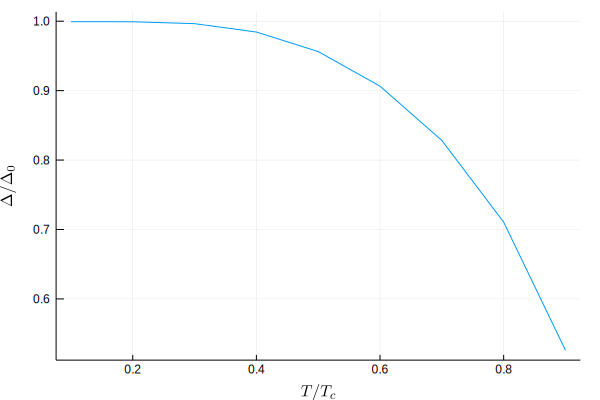

In [33]:
t=0.1:0.1:0.9
delta=GapEquation.(t)

using Plots
plot(t,1.133/2 .*delta,label="")
xaxis!("\$ T/T_c\$")
yaxis!("\$\\Delta/ \\Delta_0\$")

# エントロピー
エントロピーは、
$S(T)=-2k_BN(0)\int^{\hbar \omega_D}_{-\hbar \omega_D} d\xi \left[(1-f(E_k))\ln(1-f(E_k))+f(E_k)\ln(f(E_k)) \right]$
となる。

Entropy = S.(t, delta) = [2.90032, 2.89571, 2.88064, 2.83543, 2.73997, 2.57649, 2.32316, 1.94113, 1.32938]


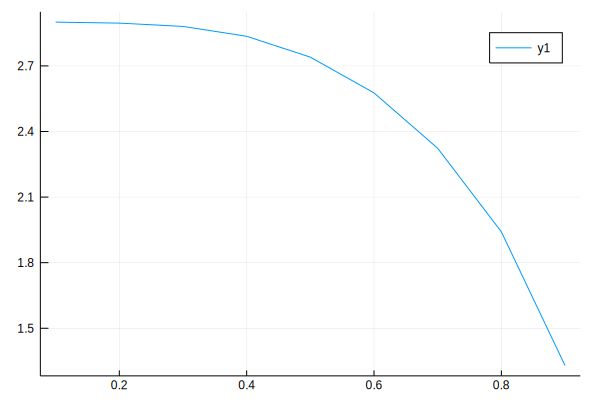

In [37]:
#フェルミ分布関数
f(x::Float64,T::Float64,Δ::Float64)=1/(exp(E(x,Δ)/T)+1)
IntegralFunctionS(x::Float64,T::Float64,Δ::Float64)=-log(1-f(x,T,Δ))+f(x,T,Δ)*E(x,Δ)/T
S(T::Float64,Δ::Float64)=quadgk(x->IntegralFunctionS(x,Δ,T),0,E_D)[1]

@show Entropy=S.(t,delta)

plot(t,Entropy)
